In [2]:
# data processing
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn for preprocessing
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# tensorflow for model building
import tensorflow as tf
from tensorflow.keras import layers, models


2023-12-08 12:23:47.137700: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-08 12:23:47.163538: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-08 12:23:47.313829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 12:23:47.313987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 12:23:47.345674: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
# custom functions
from nn_helpers import *

%load_ext autoreload
%autoreload 2

## Load the training data
This is the clean data that we processed in the notebook `Training_data_preparation`

In [4]:
data_path = "DATA/training_data/"

df = pd.read_csv(data_path + "VEX_edac_mag_labeled.csv")

In [5]:
df.head()

,EDAC,cme,BX,BY,BZ,BT,XSC,YSC,ZSC,RSC,delta_hour
0,0,0,122.866044,107.284161,109.654450,123.584061,-56.789406,-2147.243992,-70446.888658,70485.459712,1.0
1,0,0,230.881530,218.765052,216.810378,234.327848,2966.294489,-1402.796963,-72831.017578,72910.164160,1.0
2,0,0,451.576201,437.057761,440.662270,455.704559,5959.518042,-649.828442,-74422.302150,74668.263456,1.0
3,0,0,560.491882,547.190941,554.806417,566.054039,8894.553522,103.003431,-75259.615454,75788.153991,1.0
4,0,0,559.931163,548.472083,553.628791,565.035313,11745.428441,848.228357,-75367.957113,76286.992071,1.0


We separate the feature matrix `X` and the labels `y`.
- `X1` will only contain the time and EDAC data
- `X2` will contain the time, EDAC, and magneto data

In [6]:
y = df['cme'].values
X1 = df['EDAC'].values
X2 = df.drop(['cme', 'delta_hour'], axis=1).values

In [7]:
print("Shape of y:", y.shape)
print("Shape of X1:", X1.shape)
print("Shape of X2:", X2.shape)

Shape of y: (66478,)
Shape of X1: (66478,)
Shape of X2: (66478, 9)


## Class imbalance
Let's have a look at the class imbalance in our training data:

In [8]:
print('CME events in our data:')
print(df['cme'].value_counts())

cme_percentage = df['cme'].value_counts()[1] / len(df['cme']) * 100

# Print the percentage of CME events using f-strings and rounding to 2 decimal places
print(f'Percentage of CME events: {round(cme_percentage, 2)}%')

CME events in our data:
cme
0    65076
1     1402
Name: count, dtype: int64
Percentage of CME events: 2.11%


The proportion of CME events is very low: only 2% of our data corresponds to a CME.

Since we have this huge class imbalance, we can expect the models we will train to be biased towards predicting no CMEs.
We will have to implement various methods to mitigate this class imbalance later on.

## The "dumb model"
First, let's look at a model that would always predict cme = 0.

This model will have a great accuracy (since CME events are very rare) but a F1 score of 0.

We will use this "dumb model" accuracy as an indicator for our next models's accuracy.

In [9]:
pred_dumb = np.zeros_like(y)

accuracy_dumb = skm.accuracy_score(y, pred_dumb)
f1_dumb = skm.f1_score(y, pred_dumb)

print_metrics('DUMB MODEL', y, pred_dumb)

Performance of DUMB MODEL:
Accuracy: 0.98
Precision: 0.0
Recall: 0.0
F1 score: 0.0


/home/agatha/Anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Neural net models
We will buid a neural net that looks at EDAC activity in the previous `X` hours and predicts if there is a CME event going on.

We will try different values of `X`, our `window_size`:

In [10]:
window_sizes = [1, 8, 24, 168, 720]
# 1 hour, 8 hours, 1 day, 1 week, 1 month

In [11]:
metrics_array = neural_net_comp(X1, y, window_sizes, epochs=20, batch_size=32)

411/411 [==============================] - 1s 1ms/step - loss: 0.5821 - accuracy: 0.8888 - precision_4: 0.0160 - recall_4: 0.0607 - f1_score: 0.0465


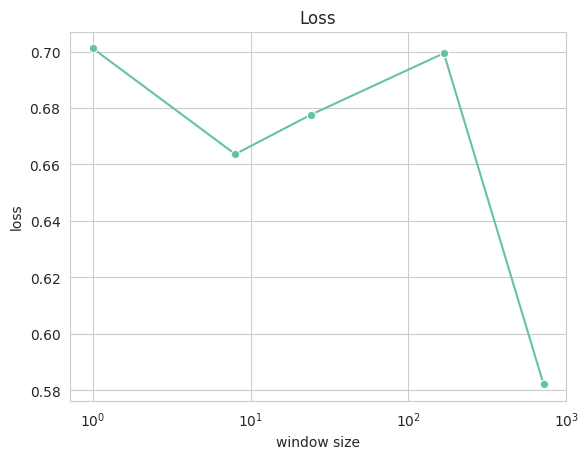

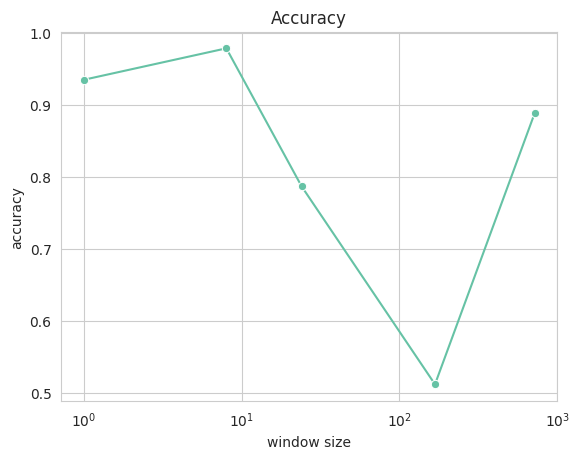

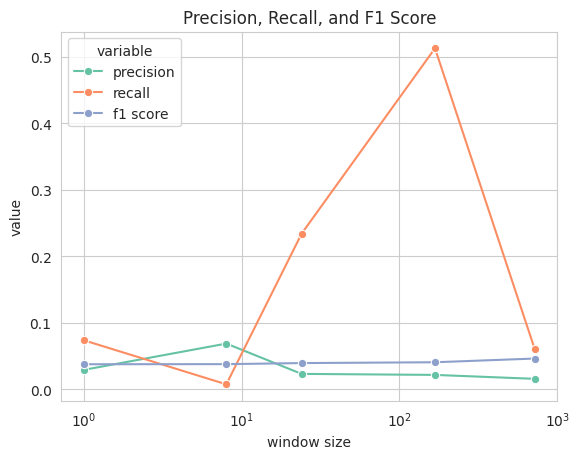

In [12]:
plot_metrics(metrics_array, window_sizes)

#### Class imbalance: adding class weights
Our previous models get an accuracy similar to the "dumb model" but the F1 score (although non zero) is still very low.
- low precision indicates that the model is making a large number of false positives (it is pretty good when we fix `window_size` at 8 or 24 hours)
- low recall indicates that the model is missing a significant number of positive instances (always very low in all our models)

This is mainly due to the fact that we have a huge class imbalance (remember that only 2% of our data corresponds to a CME event).

To mitigate this, we will focus on `window_size=8` (best precision, accuracy and loss) and we will try to add class weights, to boost intances of the minority class in our training run.

In [13]:
test_metrics_unbalanced = metrics_array[1]
# test metrics without class weights for window size 8

In [14]:
test_metrics_balanced = neural_net(X1, y, window_size=8, epochs=20, batch_size=32)

Epoch 1/20
1662/1662 [==============================] - 3s 1ms/step - loss: 0.1295 - accuracy: 0.9781 - precision_5: 0.1200 - recall_5: 0.0026 - f1_score: 0.0419
Epoch 2/20
1662/1662 [==============================] - 2s 1ms/step - loss: 0.1046 - accuracy: 0.9784 - precision_5: 0.3333 - recall_5: 0.0044 - f1_score: 0.0421
Epoch 3/20
1662/1662 [==============================] - 2s 1ms/step - loss: 0.1038 - accuracy: 0.9785 - precision_5: 0.5333 - recall_5: 0.0070 - f1_score: 0.0421
Epoch 4/20
1662/1662 [==============================] - 2s 1ms/step - loss: 0.1038 - accuracy: 0.9786 - precision_5: 0.6250 - recall_5: 0.0087 - f1_score: 0.0421
Epoch 5/20
1662/1662 [==============================] - 2s 1ms/step - loss: 0.1035 - accuracy: 0.9785 - precision_5: 0.6000 - recall_5: 0.0079 - f1_score: 0.0421
Epoch 6/20
1662/1662 [==============================] - 2s 1ms/step - loss: 0.1036 - accuracy: 0.9785 - precision_5: 0.5625 - recall_5: 0.0079 - f1_score: 0.0421
Epoch 7/20
1662/1662 [======

In [15]:
print(test_metrics_unbalanced)
print(test_metrics_balanced)

[0.6636466979980469, 0.9787138104438782, 0.06896551698446274, 0.007751937955617905, 0.03807275]
[0.09658153355121613, 0.9805942177772522, 0.0, 0.0, 0.03807275]


In [16]:
print_improvement(test_metrics_balanced, test_metrics_unbalanced, 'class weights')

Performance of the model with class weights:
Loss: 0.1
Accuracy: 0.98
Precision: 0.0
Recall: 0.0
F1 score: 0.03999999910593033

Performance difference of the model with class weights:
Loss: -0.57
Accuracy: 0.0
Precision: -0.07
Recall: -0.01
F1 score: 0.0


We see that adding class weights leads to an better precision but lowers significantly the recall, thus giving the same F1 score. We have to try other approaches.

## Feature addition: comparative study
We want to know if it is possible to build a (reasonably good) CME predictor by looking only at EDAC values. To compare the above performances, we will train a neural net whose input will be both `EDAC` and `magneto` data of the last 8 hours, 

In [24]:
#For the second model, we will use the other features in our dataset to see how much they improve our results.
#With and without class weights:
test_metrics_2_unbalanced = neural_net_dim(X2, y, window_size=8, epochs=10, batch_size=32)

Epoch 1/10
1662/1662 [==============================] - 3s 1ms/step - loss: 69.3198 - accuracy: 0.9572 - precision_14: 0.0244 - recall_14: 0.0253 - f1_score: 0.0262
Epoch 2/10
1662/1662 [==============================] - 2s 1ms/step - loss: 8.1489 - accuracy: 0.9581 - precision_14: 0.0279 - recall_14: 0.0280 - f1_score: 0.0319
Epoch 3/10
1662/1662 [==============================] - 2s 1ms/step - loss: 1.8308 - accuracy: 0.9596 - precision_14: 0.0237 - recall_14: 0.0219 - f1_score: 0.0411
Epoch 4/10
1662/1662 [==============================] - 2s 1ms/step - loss: 0.9604 - accuracy: 0.9630 - precision_14: 0.0275 - recall_14: 0.0210 - f1_score: 0.0413
Epoch 5/10
1662/1662 [==============================] - 2s 1ms/step - loss: 0.6935 - accuracy: 0.9718 - precision_14: 0.0137 - recall_14: 0.0044 - f1_score: 0.0427
Epoch 6/10
1662/1662 [==============================] - 2s 1ms/step - loss: 0.1308 - accuracy: 0.9782 - precision_14: 0.0667 - recall_14: 8.7413e-04 - f1_score: 0.0422
Epoch 7/10


In [25]:
print(test_metrics_2_unbalanced)

[0.0959475114941597, 0.9805942177772522, 0.0, 0.0, 0.03807275]


In [26]:
test_metrics_2_balanced = neural_net_dim(X2, y, window_size=8, epochs=20, batch_size=32, with_class_weights=True)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()